In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE


In [4]:
# Load the dataset
file_path = '../data/train_data.csv'  
train_data = pd.read_csv(file_path)

# Preview the data
print("First 5 rows:")
print(train_data.head())
print("\nDataset Info:")
print(train_data.info())
print("\nMissing Values:")
print(train_data.isnull().sum())

First 5 rows:
      id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...          soft   

  quality_group      quantity 

In [6]:
# Drop columns that are redundant or irrelevant
columns_to_drop = ['id', 'wpt_name', 'subvillage', 'region_code', 'scheme_name', 'recorded_by']
train_data.drop(columns=columns_to_drop, inplace=True)


In [7]:
# Fill missing values for categorical and numerical columns
train_data['funder'].fillna('Unknown', inplace=True)
train_data['installer'].fillna('Unknown', inplace=True)
train_data['public_meeting'].fillna(False, inplace=True)
train_data['permit'].fillna(False, inplace=True)
train_data['scheme_management'].fillna('Unknown', inplace=True)

# Verify no missing values
print("\nRemaining Missing Values:")
print(train_data.isnull().sum())



Remaining Missing Values:
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
num_private              0
basin                    0
region                   0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
status_group             0
dtype: int64


In [27]:
# Create a new feature: Age of the well
from datetime import datetime

# Dynamically calculate the current year
current_year = datetime.now().year

# Create a new feature: Age of the well
train_data['well_age'] = current_year - train_data['construction_year']

# Replace invalid or missing years with 0
train_data['well_age'] = train_data['well_age'].replace({current_year: 0})

# Verify
print(train_data[['construction_year', 'well_age']].head())


   construction_year  well_age
0               1999        25
1               2010        14
2               2009        15
3               1986        38
4                  0         0


In [35]:
train_data['well_age'].min()

0

## EDA

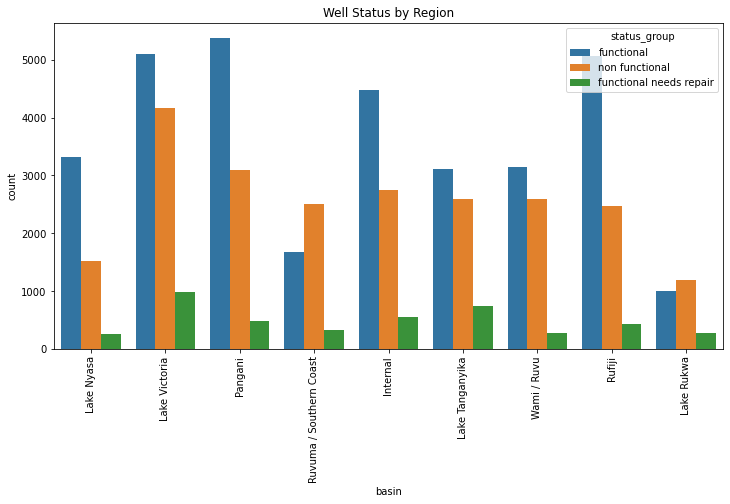

In [36]:
#Well status by region
plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, x='basin', hue='status_group')
plt.xticks(rotation=90)
plt.title("Well Status by Region")
plt.show()

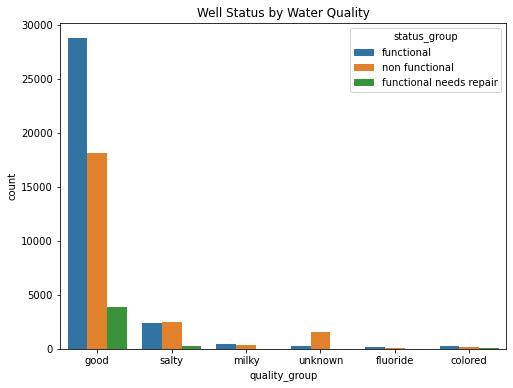

In [29]:
# water quality and well status
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='quality_group', hue='status_group')
plt.title("Well Status by Water Quality")
#plt.xlabel()
plt.show()

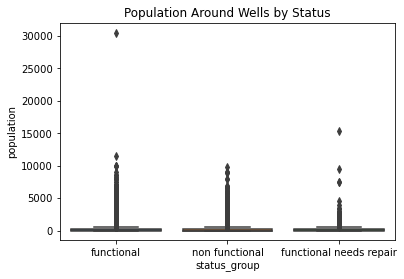

In [30]:
# well status by population
sns.boxplot(data=train_data, x='status_group', y='population')
plt.title("Population Around Wells by Status")
plt.show()

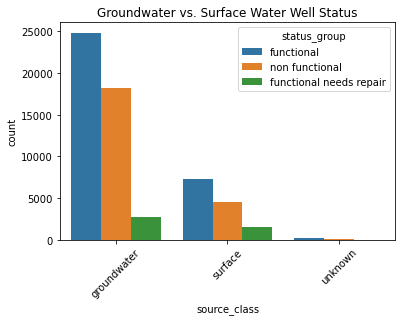

In [31]:
#Ground Vs Surface water
sns.countplot(data=train_data, x='source_class', hue='status_group')
plt.xticks(rotation=45)
plt.title("Groundwater vs. Surface Water Well Status")
plt.show()


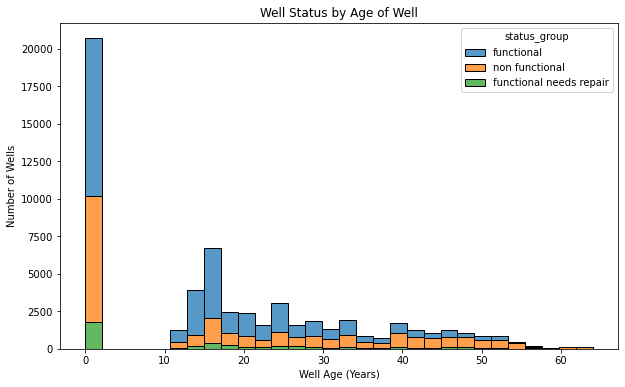

In [34]:
#Well age and failure
# Histogram plot of well age by status_group
plt.figure(figsize=(10, 6))
sns.histplot(
    data=train_data,
    x='well_age',
    hue='status_group',
    multiple='stack',
    bins=30
)
plt.title("Well Status by Age of Well")
plt.xlabel('Well Age (Years)')
plt.ylabel('Number of Wells')
plt.show()


Encoding categoricals

In [ ]:
# Identify categorical columns
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_columns)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_features(data):
   
    # Identify low and high cardinality columns
    low_cardinality_cols = ['payment', 'management', 'water_quality', 
                            'scheme_management','source','basin',
                            'payment_type','waterpoint_type','management_group',
                            'quantity']  
    high_cardinality_cols = ['funder', 'installer','ward','lga','region',
                             'extraction_type','date_recorded']          

    # One-Hot Encoding for low-cardinality columns
    data = pd.get_dummies(data, columns=low_cardinality_cols, drop_first=True)

    # Label Encoding for high-cardinality columns
    label_encoder = LabelEncoder()
    for col in high_cardinality_cols:
        data[col] = label_encoder.fit_transform(data[col])

    return data

# Apply encoding to the train_data DataFrame
train_data = encode_features(train_data)

5.0 Scaling Numerical Features

In [ ]:
# Identify numerical columns
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns
print("Numerical Columns:", numerical_columns)

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical columns
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])

6.0 Splitting data

In [ ]:
# Define features and target
target_column = 'status_group'
X = train_data.drop(columns=[target_column])
y = train_data[target_column]
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

# Building a dummy model using a dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize a dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")  # Predicts the most frequent class
dummy_clf.fit(X_train, y_train)

# Make predictions on the test set
y_dummy_pred = dummy_clf.predict(X_test)

# Evaluate dummy model
print("Dummy Model Accuracy:", accuracy_score(y_test, y_dummy_pred))
print("\nClassification Report for Dummy Model:")
print(classification_report(y_test, y_dummy_pred,zero_division=0))

# Building a Logistic Regression Model

In [ ]:
# Initializing logistic regression
from sklearn.metrics import confusion_matrix
# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test_scaled)

Model evaluation

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

In [ ]:
# Predict probabilities
y_probs = log_reg.predict_proba(X_test_scaled)

# Calculate ROC-AUC (multi-class, one-vs-rest)
roc_auc = roc_auc_score(y_test, y_probs, multi_class="ovr")
print(f"\nROC-AUC Score: {roc_auc:.2f}")

Results Analysis
1. Accuracy
72% Accuracy: This is an improvement over the dummy model, indicating that Logistic Regression is capturing some patterns in the data.

2. Classification Report
- functional:

Precision: 0.70 → 70% of predicted functional wells are truly functional.
Recall: 0.89 → 89% of actual functional wells are correctly identified.
F1-score: 0.79 → A balance between precision and recall, indicating good performance.

- functional needs repair:

Precision: 0.46 → 46% of predictions for this class are correct.
Recall: 0.05 → Very low recall indicates the model struggles to detect wells needing repair.
F1-score: 0.09 → The model's predictions for this class are quite poor.

- non functional:

Precision: 0.78 → 78% of predicted non-functional wells are truly non-functional.
Recall: 0.61 → The model identifies 61% of actual non-functional wells.
F1-score: 0.68 → Decent performance, though recall could be improved.

3. Macro and Weighted Averages
Macro Avg: Average performance across all classes, unweighted. Lower scores reflect poor performance for the minority class (functional needs repair).
Weighted Avg: Average performance weighted by class support (the number of instances per class). Reflects overall performance better.

4. Confusion Matrix
Diagonal Values (Correct Predictions):
Functional: 5779 out of 6457.
Needs Repair: 42 out of 851.
Non-functional: 2774 out of 4572.

Off-Diagonal Values (Misclassifications):
Many non-functional wells are misclassified as functional (1782 cases).
Very few needs repair wells are identified correctly.

*Key Observations*

Class Imbalance:

The minority class (functional needs repair) is poorly predicted, as Logistic Regression doesn't handle class imbalance well.

Misclassifications:

Significant overlap between functional and non-functional wells, suggesting overlapping feature distributions.